In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import ast

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

## AFIB 라벨링

### PTB-XL

In [4]:
df_ptb = pd.read_csv('./ptb_xl_data/ptbxl_database.csv', index_col='ecg_id')

df_ptb.scp_codes = df_ptb.scp_codes.apply(lambda x: ast.literal_eval(x))
df_ptb.scp_codes = df_ptb.scp_codes.apply(lambda x: list(x.keys()))

df_ptb['label'] = df_ptb.scp_codes.apply(lambda arr: 1 if 'AFIB' in arr else 0)

df_ptb.label.value_counts() 

# 21799개 중 1514개. 6.95% 샘플 불균형

label
0    20285
1     1514
Name: count, dtype: int64

## SPH

In [5]:
df_sph = pd.read_csv("./sph_data/metadata.csv", index_col='ECG_ID')

# 'AHA_Code' 컬럼의 각 값에 대해 '50'이 포함되어 있는지 확인하고, 'label' 컬럼 생성
def check_contains_50(code):
    # 공백을 없애고, ';' 또는 '+'로 분리
    numbers = code.replace(' ', '').replace('+', ';').split(';')
    # '50'이 포함되어 있는지 확인
    return '50' in numbers

# 'label' 컬럼 생성
df_sph['label'] = df_sph['AHA_Code'].apply(check_contains_50).astype(int)

df_sph.label.value_counts()

# 25770 개 중 675개. 2.62% 샘플 불균형

label
0    25095
1      675
Name: count, dtype: int64

## 데이터 준비
- data_prep.py

In [6]:
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader, TensorDataset
import random

# 시드 설정 _20231125추가
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # 멀티 GPU를 사용하는 경우
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [7]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold


# custom_file 폴더에서 lead1_signals 데이터 로드
lead1_signals = np.load('./custom_file/annie_ptb_xl_lead1.npy')


# 레이블 데이터 로드
labels = df_ptb['label'].values


# 데이터 정규화
lead1_signals_normalized = (lead1_signals - lead1_signals.mean()) / (lead1_signals.std()+1e-7)


# 데이터셋을 텐서로 변환
X = torch.Tensor(lead1_signals_normalized)
y = torch.Tensor(labels).long()  


# 데이터 분할
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# 채널 수를 1로 추가_GOOD
X_train = X_train.unsqueeze(1)
X_val = X_val.unsqueeze(1)
X_test = X_test.unsqueeze(1)


# DataLoader 생성
train_data = TensorDataset(X_train, y_train)
val_data = TensorDataset(X_val, y_val)
test_data = TensorDataset(X_test, y_test)

batch_size = 64
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
val_loader = DataLoader(val_data, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)


# 간단한 CNN 모델 구축
class SimpleCNN(torch.nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = torch.nn.Conv1d(1, 32, kernel_size=7, stride=2) 
        self.pool = torch.nn.MaxPool1d(kernel_size=5, stride=1) 
        self.conv2 = torch.nn.Conv1d(32, 64, kernel_size=5) 
        self.fc1 = torch.nn.Linear(64 * 2485, 1000) 
        self.fc2 = torch.nn.Linear(1000, 500)
        self.fc3 = torch.nn.Linear(500, 1)

    def forward(self, x):
        x = self.pool(torch.nn.functional.leaky_relu(self.conv1(x)))
        x = self.pool(torch.nn.functional.leaky_relu(self.conv2(x)))
        x = x.view(-1, 64 * 2485)
        x = torch.nn.functional.leaky_relu(self.fc1(x))
        x = torch.nn.functional.leaky_relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = SimpleCNN()

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from sklearn.metrics import roc_auc_score
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import roc_curve, auc
import seaborn as sns

# 모델을 GPU로 옮기기
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN().to(device)

# 손실 함수 정의 (이진 크로스 엔트로피)
criterion = torch.nn.BCEWithLogitsLoss()

# 옵티마이저 선택 (Adam)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 학습 및 검증 손실과 정확도를 기록할 리스트
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
val_aurocs = []

# 학습 루프 설정
num_epochs = 10
for epoch in range(num_epochs):
    # 훈련 데이터 루프
    model.train()
    train_loss = 0.0
    train_preds = []
    train_targets = []
    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
        inputs, labels = inputs.to(device), labels.to(device)  # 데이터를 GPU로 이동
        optimizer.zero_grad()  # 그래디언트 초기화

        # 순전파 및 역전파
        outputs = model(inputs)
        loss = criterion(outputs.view(-1), labels.float())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_preds.extend(torch.sigmoid(outputs).view(-1).cpu().detach().numpy())
        train_targets.extend(labels.cpu().numpy())

    train_loss /= len(train_loader)
    train_accuracy = accuracy_score(train_targets, np.round(train_preds))
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # 검증 데이터 루프
    model.eval()
    val_preds = []
    val_targets = []
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs.view(-1), labels.float())
            val_loss += loss.item()
            val_preds.extend(torch.sigmoid(outputs).view(-1).cpu().detach().numpy())
            val_targets.extend(labels.cpu().numpy())

    val_loss /= len(val_loader)
    val_accuracy = accuracy_score(val_targets, np.round(val_preds))
    val_auroc = roc_auc_score(val_targets, val_preds)

    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    # 에포크의 결과 출력
    #print(f'Epoch [{epoch + 1}/{num_epochs}] - Train Loss: {train_loss:.4f} - Train Accuracy: {train_accuracy:.4f} - Validation Loss: {val_loss:.4f} - Validation Accuracy: {val_accuracy:.4f} - Validation AUROC: {val_auroc:.4f}')
    print(f'Epoch [{epoch + 1}/{num_epochs}] - Validation AUROC: {val_auroc:.4f}')
    val_aurocs.append(val_auroc)
    
# 테스트 데이터 루프
model.eval()
test_preds = []
test_targets = []
with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc=f"Testing"):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        test_preds.extend(torch.sigmoid(outputs).view(-1).cpu().detach().numpy())
        test_targets.extend(labels.cpu().numpy())

test_accuracy = accuracy_score(test_targets, np.round(test_preds))
test_auroc = roc_auc_score(test_targets, test_preds)
print(f'Test Accuracy: {test_accuracy * 100:.2f}% - Test AUROC: {test_auroc:.4f}')

Epoch 1/10 - Training: 100%|██████████| 273/273 [00:23<00:00, 11.60it/s]


Epoch [1/10] - Validation AUROC: 0.6796


Epoch 2/10 - Training: 100%|██████████| 273/273 [00:20<00:00, 13.60it/s]


Epoch [2/10] - Validation AUROC: 0.6816


Epoch 3/10 - Training: 100%|██████████| 273/273 [00:20<00:00, 13.48it/s]


Epoch [3/10] - Validation AUROC: 0.7655


Epoch 4/10 - Training: 100%|██████████| 273/273 [00:19<00:00, 13.73it/s]


Epoch [4/10] - Validation AUROC: 0.7495


Epoch 5/10 - Training: 100%|██████████| 273/273 [00:19<00:00, 13.74it/s]


Epoch [5/10] - Validation AUROC: 0.7641


Epoch 6/10 - Training: 100%|██████████| 273/273 [00:19<00:00, 13.70it/s]


Epoch [6/10] - Validation AUROC: 0.7505


Epoch 7/10 - Training: 100%|██████████| 273/273 [00:20<00:00, 13.44it/s]


Epoch [7/10] - Validation AUROC: 0.7508


Epoch 8/10 - Training: 100%|██████████| 273/273 [00:20<00:00, 13.46it/s]


Epoch [8/10] - Validation AUROC: 0.7546


Epoch 9/10 - Training: 100%|██████████| 273/273 [00:20<00:00, 13.50it/s]


Epoch [9/10] - Validation AUROC: 0.7629


Epoch 10/10 - Training: 100%|██████████| 273/273 [00:20<00:00, 13.61it/s]


Epoch [10/10] - Validation AUROC: 0.7424


Testing: 100%|██████████| 35/35 [00:00<00:00, 77.47it/s]

Test Accuracy: 92.61% - Test AUROC: 0.7124


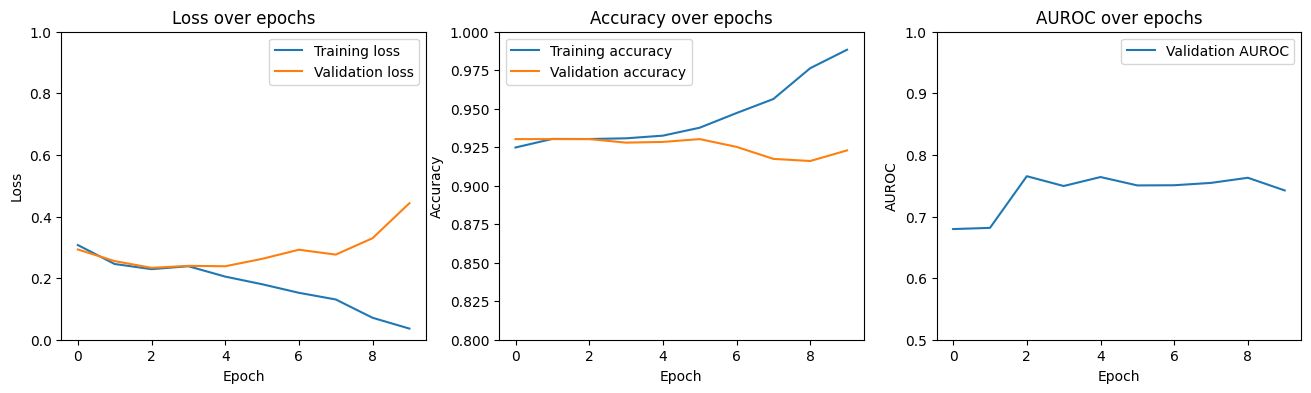

In [9]:
# 손실, 정확도, AUROC 그래프 그리기
plt.figure(figsize=(16, 4))

# 손실 그래프
plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0.0, 1.0)  # y축 범위 설정
plt.legend()

# 정확도 그래프
plt.subplot(1, 3, 2)
plt.plot(train_accuracies, label='Training accuracy')
plt.plot(val_accuracies, label='Validation accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0.8, 1.0)  # y축 범위 설정
plt.legend()

# AUROC 그래프
plt.subplot(1, 3, 3)
plt.plot(val_aurocs, label='Validation AUROC')
plt.title('AUROC over epochs')
plt.xlabel('Epoch')
plt.ylabel('AUROC')
plt.ylim(0.5, 1.0)  # y축 범위 설정
plt.legend()

plt.show()

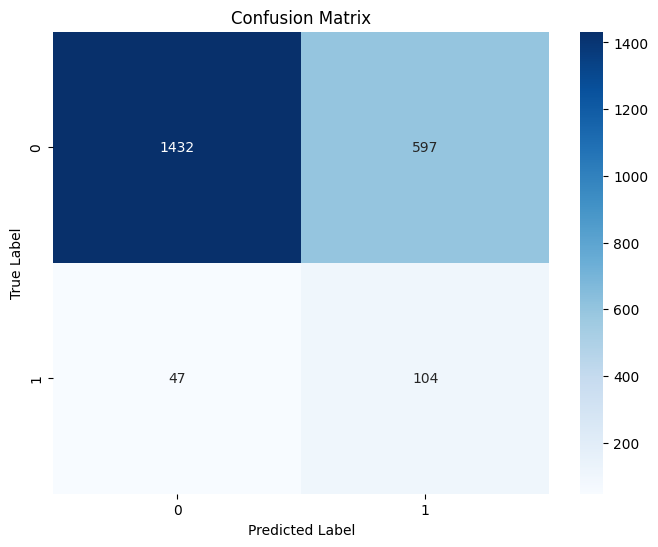

Accuracy: 0.7046
Precision: 0.1484
Recall: 0.6887
F1 Score: 0.2441
Optimal Threshold (Youden Index): 0.0019004778


In [10]:

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import torch

# 모델을 평가 모드로 설정
model.eval()

# 모든 확률과 레이블을 저장할 리스트 초기화
all_preds_probs = []
all_labels = []

# 테스트 데이터에 대한 예측 수행 (확률만 계산)
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        probs = torch.sigmoid(outputs).view(-1)  # 시그모이드 함수 적용
        all_preds_probs.extend(probs.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# 예측 확률과 실제 레이블을 사용하여 ROC 커브 계산
fpr, tpr, thresholds = roc_curve(all_labels, all_preds_probs)

# Youden의 지수 계산
youden_index = tpr - fpr

# 최대 Youden 지수를 가진 임계값 찾기
optimal_idx = np.argmax(youden_index)
optimal_threshold = thresholds[optimal_idx]

# 최적 임계값을 사용하여 예측 수행
all_predictions = (np.array(all_preds_probs) > optimal_threshold).astype(int)

# 성능 지표 계산
accuracy = accuracy_score(all_labels, all_predictions)
precision = precision_score(all_labels, all_predictions)
recall = recall_score(all_labels, all_predictions)
f1 = f1_score(all_labels, all_predictions)

# 혼동 행렬 생성
cm = confusion_matrix(all_labels, all_predictions)

# 혼동 행렬 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# 성능 지표 출력
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print("Optimal Threshold (Youden Index):", optimal_threshold)

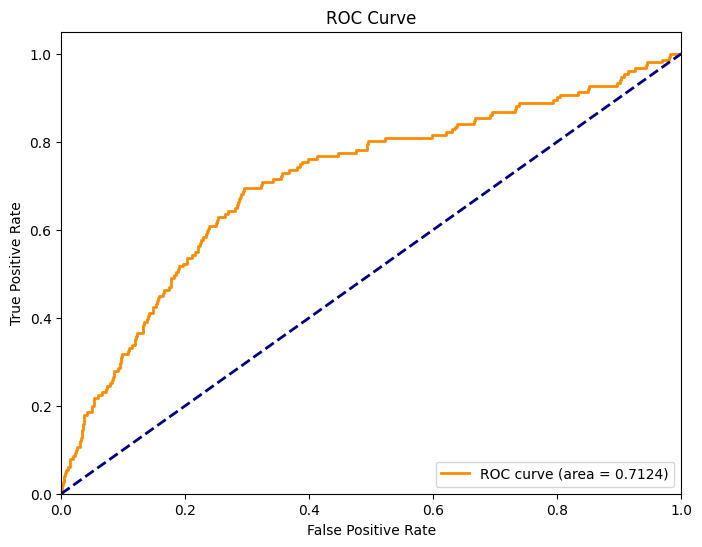

AUROC: 0.7124


In [11]:
# 예측 확률을 저장할 리스트
all_preds_probs = []

# 모델을 평가 모드로 설정
model.eval()

# 테스트 데이터에 대한 예측 확률 수행
with torch.no_grad():
    for inputs, _ in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        # sigmoid를 사용하여 확률을 계산
        probs = torch.sigmoid(outputs)
        all_preds_probs.extend(probs.cpu().numpy())

# 실제 레이블과 예측 확률을 사용하여 ROC 커브 계산
fpr, tpr, _ = roc_curve(all_labels, all_preds_probs)
roc_auc = auc(fpr, tpr)

# AUROC 그래프를 그립니다.
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

# AUROC 점수를 출력합니다.
print(f'AUROC: {roc_auc:.4f}')


## SPH 테스트

In [12]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import TensorDataset, DataLoader

# SPH 데이터 로드 및 전처리
sph_signals = np.load('./custom_file/annie_sph_lead1.npy')

# 데이터 정규화
sph_signals_normalized = (sph_signals - sph_signals.mean()) / (sph_signals.std() + 1e-7)

# 데이터셋을 텐서로 변환
X_sph = torch.Tensor(sph_signals_normalized)
y_sph = torch.Tensor(df_sph['label'].values).long()

# 채널 수를 1로 추가
X_sph = X_sph.unsqueeze(1)

# DataLoader 생성
sph_data = TensorDataset(X_sph, y_sph)
sph_loader = DataLoader(sph_data, batch_size=batch_size)

# SPH 데이터셋으로 모델 테스트
model.eval()
sph_preds = []
sph_targets = []
with torch.no_grad():
    for inputs, labels in tqdm(sph_loader, desc="Testing on SPH Data"):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        sph_preds.extend(torch.sigmoid(outputs).view(-1).cpu().detach().numpy())
        sph_targets.extend(labels.cpu().numpy())

sph_accuracy = accuracy_score(sph_targets, np.round(sph_preds))
sph_auroc = roc_auc_score(sph_targets, sph_preds)
print(f'SPH Test Accuracy: {sph_accuracy * 100:.2f}% - SPH Test AUROC: {sph_auroc:.4f}')

/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:239: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:250: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
Testing on SPH Data: 100%|██████████| 403/403 [00:05<00:00, 77.72it/s]

SPH Test Accuracy: 97.38% - SPH Test AUROC: 0.4999


In [19]:
# SPH 데이터 로드 및 전처리
sph_signals = np.load('./custom_file/annie_sph_lead1.npy')

# 데이터 정규화
# sph_signals_normalized = (sph_signals - sph_signals.mean()) / (sph_signals.std() + 1e-7)

In [ ]:
sph_signals

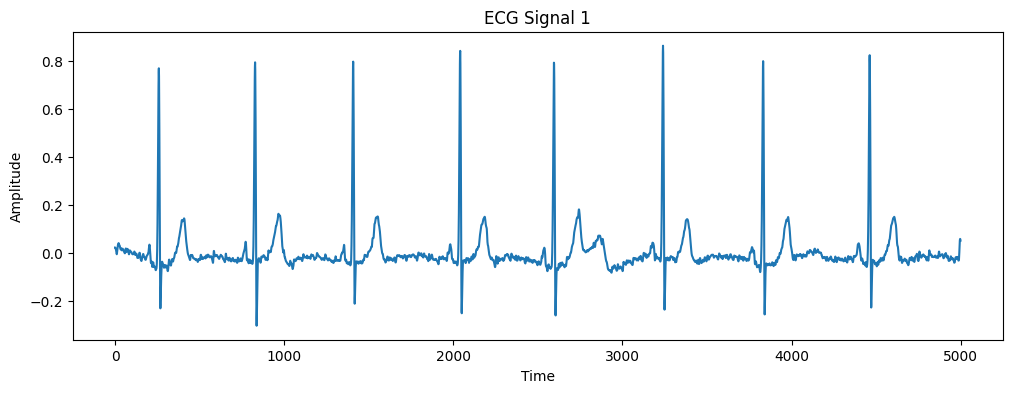

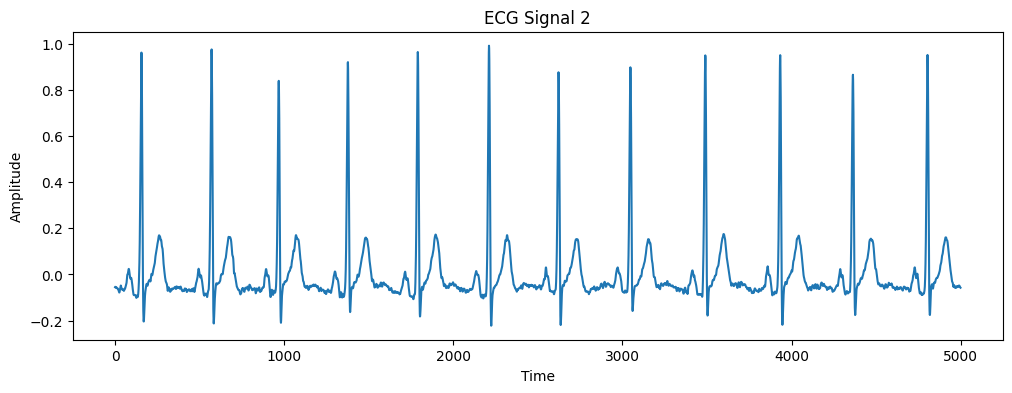

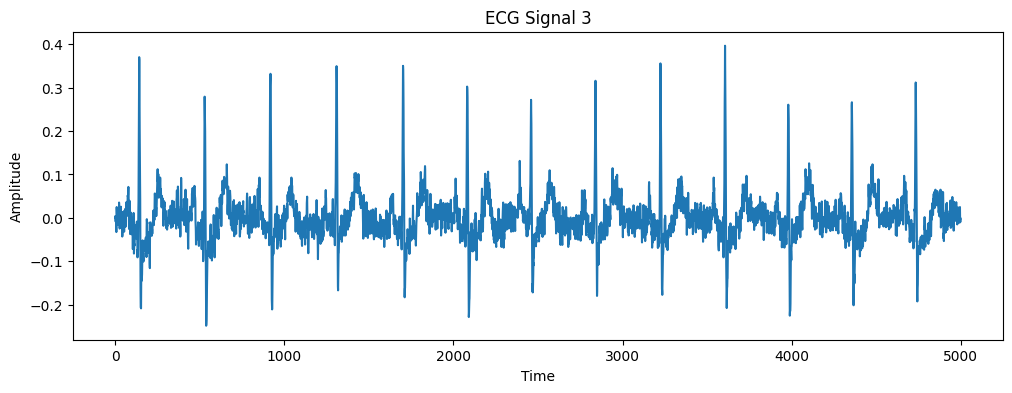

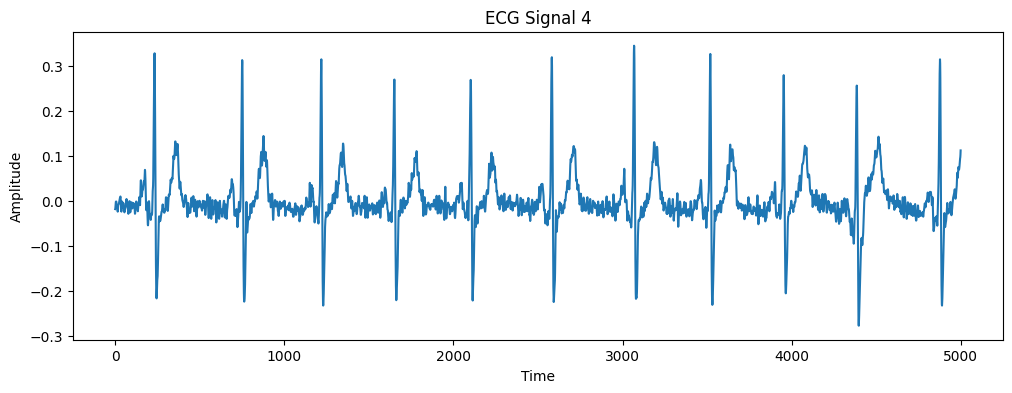

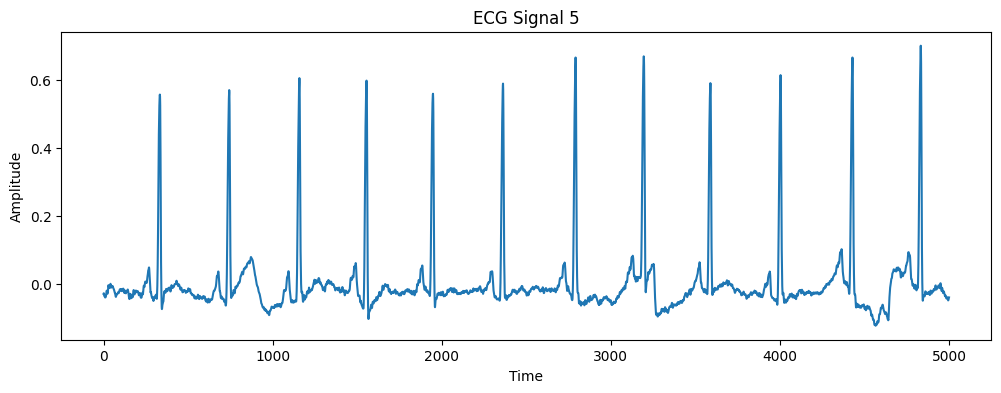

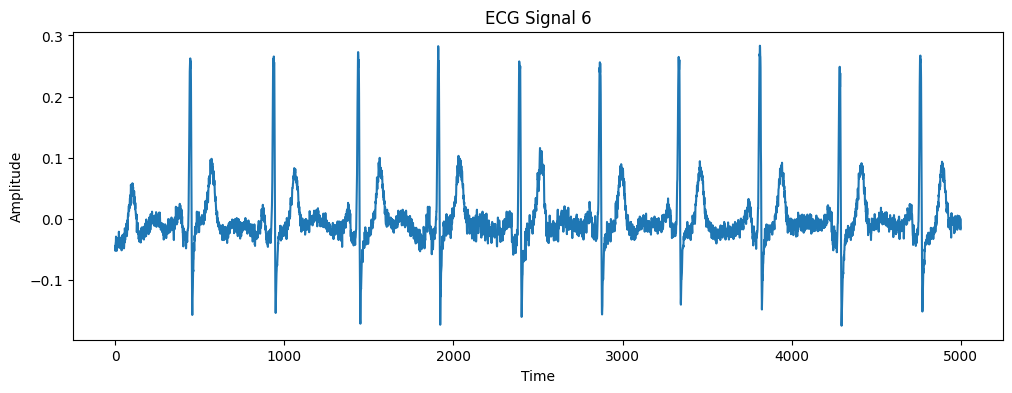

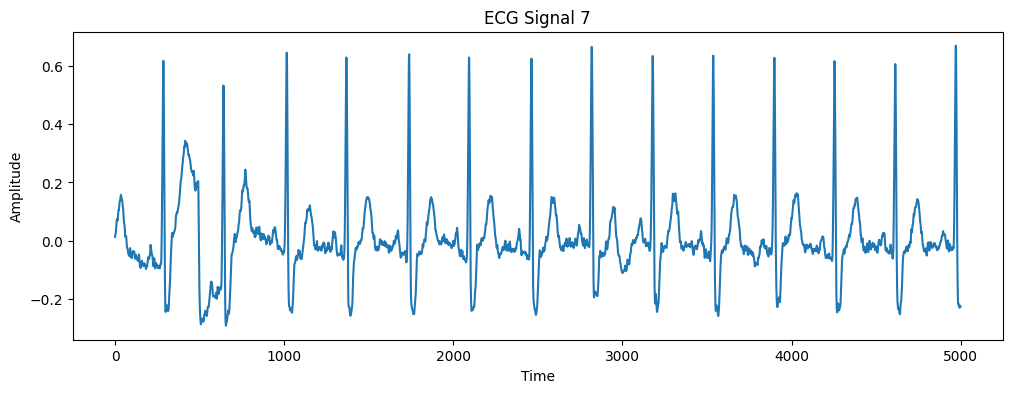

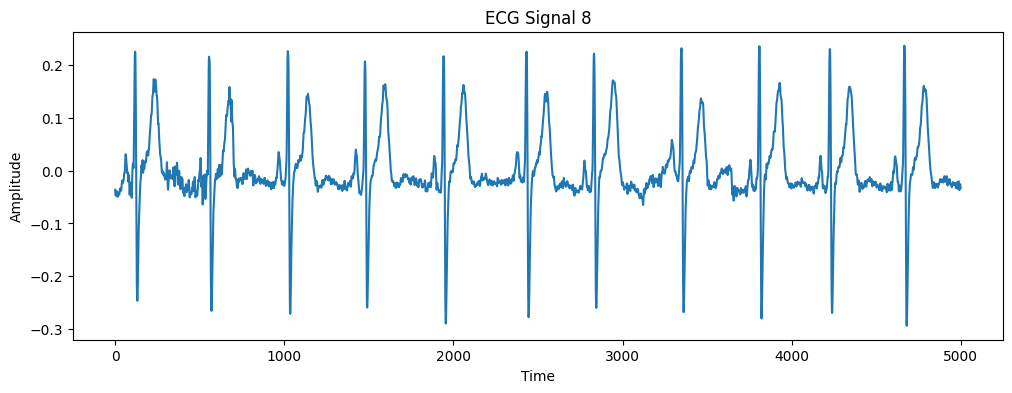

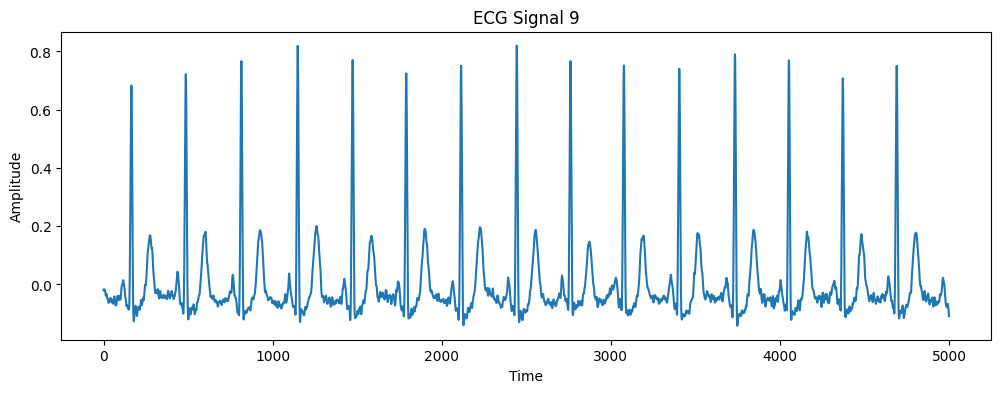

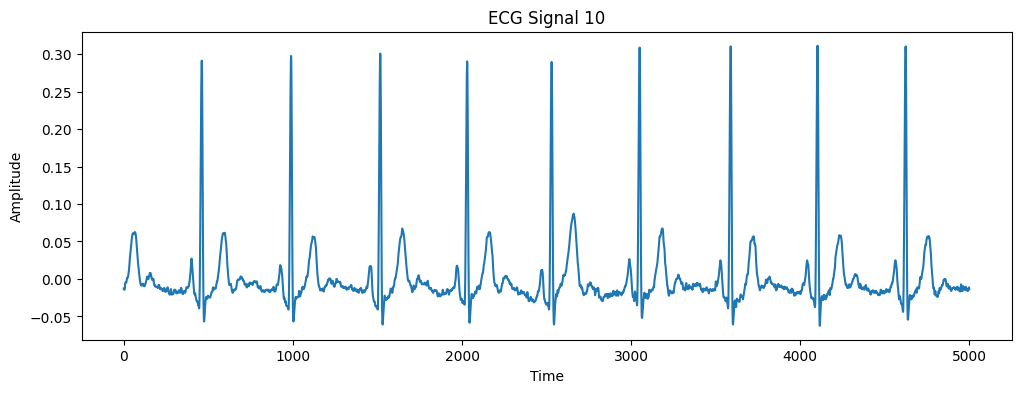

In [20]:
# 개별 신호 시각화
def plot_ecg_signal(signal, title="ECG Signal"):
    plt.figure(figsize=(12, 4))
    plt.plot(signal)
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.show()

# 몇 개의 신호 시각화
for i in range(10):
    plot_ecg_signal(sph_signals[i], title=f"ECG Signal {i+1}")